#### Dependencies

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

# geo libs are optional
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [5]:
# cd ../..

In [6]:
pwd   # should be top-level, i.e. ~/*/generative-downscaling/

'/home/jake/Projects/mila/6759/generative-downscaling'

In [7]:
temp_1 = xr.open_dataset("./data/raw/temp/1406/2m_temperature_1991_1.40625deg.nc")
temp_5 = xr.open_dataset("./data/raw/temp/5625/2m_temperature_1991_5.625deg.nc")

#### Basic XArray

In [8]:
temp_1

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256, time: 8760)
Coordinates:
  * lat      (lat) float64 -89.3 -87.89 -86.48 -85.08 ... 85.08 86.48 87.89 89.3
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * time     (time) datetime64[ns] 1991-01-01 ... 1991-12-31T23:00:00
Data variables:
    t2m      (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-07 05:53:15 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [9]:
temp_1.dims  # 8760/365 = 24!

Frozen({'lat': 128, 'lon': 256, 'time': 8760})

In [10]:
temp_5.dims

Frozen({'lat': 32, 'lon': 64, 'time': 8760})

In [11]:
temp_1.coords

Coordinates:
  * lat      (lat) float64 -89.3 -87.89 -86.48 -85.08 ... 85.08 86.48 87.89 89.3
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * time     (time) datetime64[ns] 1991-01-01 ... 1991-12-31T23:00:00

In [12]:
type(temp_1.t2m.data)

numpy.ndarray

#### Basic Filtering

In [13]:
daily = temp_1.isel(time=(temp_1.time.dt.hour == 0))
daily.dims

Frozen({'lat': 128, 'lon': 256, 'time': 365})

In [14]:
daily_5 = temp_5.isel(time=(temp_5.time.dt.hour == 0))
daily.dims

Frozen({'lat': 128, 'lon': 256, 'time': 365})

## Visual Exploration

### Location & Consistency

#### Where is the Data Located?

In [17]:
def obs_by_geo(weatherbench: pd.DataFrame) -> GeoDataFrame:
    """ Return total observations by coordinate """
    obs_by_geo = weatherbench.groupby(["lat","lon"]).size()
    obs_by_geo.name = "count"
    obs_by_geo = obs_by_geo.reset_index()

    gdf = GeoDataFrame(
        obs_by_geo,
        geometry=gpd.points_from_xy(obs_by_geo.lon - 180, obs_by_geo.lat)
    )

    return gdf

In [18]:
fine_cts = obs_by_geo(daily.to_dataframe())
coarse_cts = obs_by_geo(daily_5.to_dataframe())

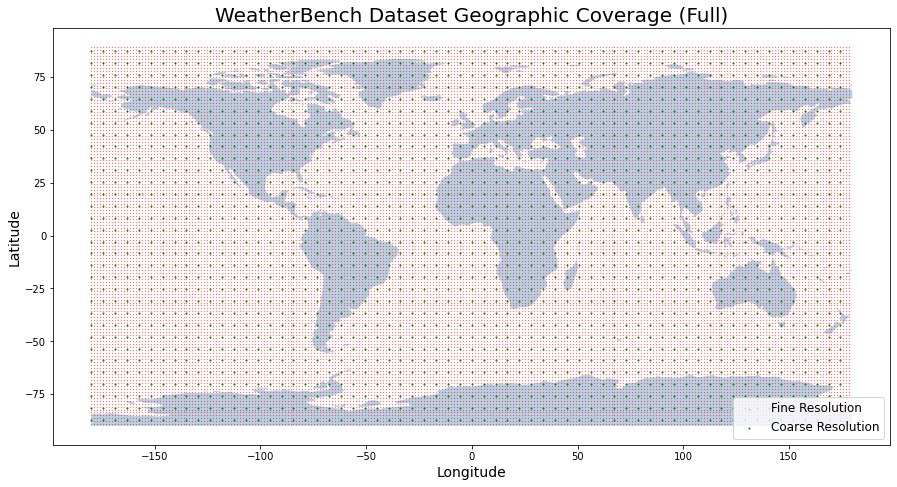

In [21]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = fine_cts.plot(
    ax=world.plot(figsize=(15, 8), alpha=.33),
    marker='o', color='red', markersize=.05,
    label = "Fine Resolution"
);

coarse_cts.plot(
    ax=ax,
    marker='o', color='green', markersize=1,
    label = "Coarse Resolution"
);

ax.set_title("WeatherBench Dataset Geographic Coverage (Full)", fontsize=20);
ax.set_xlabel("Longitude", fontsize=14);
ax.set_ylabel("Latitude", fontsize=14);
ax.legend(fontsize=12);

#### Americas Only

In [22]:
EPSILON = .0001
NA_LAT_FINE = (-5, 85+EPSILON)  # epsilon to avoid non-inclusive right
NA_LON_FINE = (-137.5+180, -47.5+180+EPSILON)

NA_LAT_COARSE = (-10, 88+EPSILON)  # Coarse should be wider for full coverage
NA_LON_COARSE = (-145+180, -45+180+EPSILON)

daily_na = daily.sel(lat=slice(*NA_LAT_FINE), lon=slice(*NA_LON_FINE))
daily_na_5 = daily_5.sel(lat=slice(*NA_LAT_COARSE), lon=slice(*NA_LON_COARSE))

In [29]:
fine_cts_americas = fine_cts[fine_cts['lat'].between(*NA_LAT_FINE) & fine_cts['lon'].between(*NA_LON_FINE)]
coarse_cts_americas = coarse_cts[coarse_cts['lat'].between(*NA_LAT_COARSE) & coarse_cts['lon'].between(*NA_LON_COARSE)]

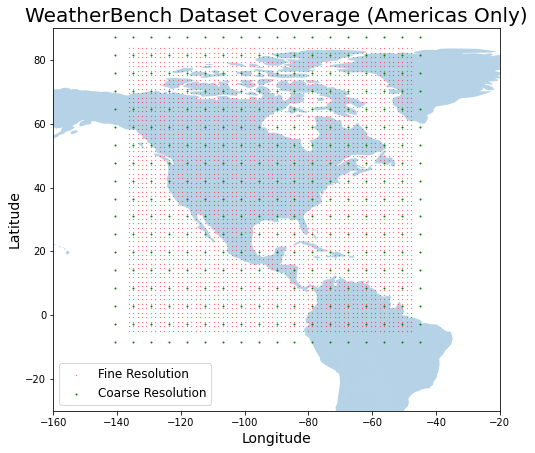

In [30]:
americas = world[world['continent'].isin(["North America", "South America"])]

ax = fine_cts_americas.plot(
    ax=americas.plot(figsize=(8,8), alpha=.33),
    marker='o', color='red', markersize=.05,
    label = "Fine Resolution"
);

coarse_cts_americas.plot(
    ax=ax,
    marker='o', color='green', markersize=1,
    label = "Coarse Resolution"
);

ax.set_xlim(-160,-20);
ax.set_ylim(-30,90);

ax.set_title("WeatherBench Dataset Coverage (Americas Only)", fontsize=20);
ax.set_xlabel("Longitude", fontsize=14);
ax.set_ylabel("Latitude", fontsize=14);
ax.legend(fontsize=12);

### Temperature

In [65]:
t5_pdf = temp_5.to_dataframe()
# t5_pdf = t5_pdf[:100]

In [71]:
# coords = t5_pdf.reset_index()[['lat','lon']].drop_duplicates()
# coords[coords['lat'].between(40,50) & coords['lon'].between(70+180,80+180)]

coords_mtl_approx = (47.8125, 253.125)  # lat, lon

In [82]:
mtl_1991 = t5_pdf.loc[coords_mtl_approx[0]].loc[coords_mtl_approx[1]]

In [91]:
mtl_1991_hi_lo = mtl_1991\
    .groupby([mtl_1991.index.date])\
    .agg([np.min, np.max])\
    .rename(columns={'amin': 'low', 'amax': 'high'})

mtl_1991_hi_lo_c = mtl_1991_hi_lo - 273.15  # kelvin to celsius

<AxesSubplot:>

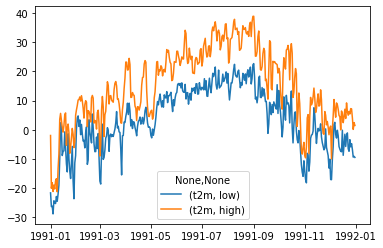

In [92]:
mtl_1991_hi_lo_c.plot()